In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
from astropy import units as u
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable

# PSD code
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx
import poppy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 06/12/2020 02:46:13


In [4]:
%%time
# initialize the data
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 0.019*u.m, #19*u.mm,
             'label': '19mm',
             'fm_num': 1,
             'surf_units': u.micron,
             'ring_width': 3,
             'kmid_ll': 100/u.m, #0.1/u.mm,
             'khigh_ll': 1000/u.m} #1/u.mm}

fits_folder = 'zygo_data/flat_mirrors/fixed_fits/'
fm_loc = fits_folder+'flat_{0}_n{1}_{2}CA_glue'.format(opt_parms['label'], opt_parms['fm_num'], opt_parms['ca'])

fm = psd.surfPSD(surf_name='fm_{0}'.format(opt_parms['label']))
fm.open_surf(fileloc=fm_loc+'_surf.fits', surf_units=opt_parms['surf_units'])
fm.open_mask(fileloc=fm_loc+'_mask.fits')
fm.calc_psd(oversamp=opt_parms['ovs'], kmid_ll=opt_parms['kmid_ll'], khigh_ll=opt_parms['khigh_ll'])
fm.calc_psd_radial(ring_width=opt_parms['ring_width'], kmin=fm.k_min)
fm.write_psd_file(filename=fits_folder+'flat_{0}_ca{1}_gluedata_PSD.fits'.format(opt_parms['label'], opt_parms['ca']),
                  psd_data=fm.psd_cal,
                  single_precision=False)

# add in values to opt_parms to make code easier to use
opt_parms['dk'] = fm.delta_k
opt_parms['diam_ca'] = fm.diam_ca
opt_parms['diam_pix'] = fm.npix_diam
opt_parms['wavelen'] = fm.wavelen

CPU times: user 2min 43s, sys: 57.3 s, total: 3min 40s
Wall time: 3min 40s


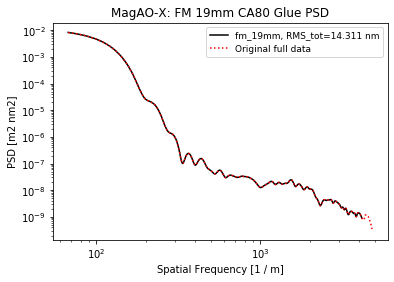

In [6]:
# throw away some of the super high-k ending data for better fitting
# Warning: do not rerun this else the size keeps changing
old_k = copy.copy(fm.k_radial)
old_psd = copy.copy(fm.psd_radial_cal)

fin = len(fm.k_radial)
offset = 250
fm.k_radial = fm.k_radial[0:fin-offset]
fm.psd_radial_cal = fm.psd_radial_cal[0:fin-offset]

plt.figure()
plt.loglog(fm.k_radial.value, fm.psd_radial_cal.value, 'k', 
           label='{0}, RMS_tot={1:.3f}'.format(fm.surf_name, fm.rms_tot))
plt.loglog(old_k.value, old_psd.value, 'r:',
           label='Original full data')
plt.xlabel('Spatial Frequency [{0}]'.format(fm.k_radial.unit))
plt.ylabel('PSD [{0}]'.format(fm.psd_radial_cal.unit))
plt.title('MagAO-X: FM {0} CA{1} Glue PSD'.format(opt_parms['label'], opt_parms['ca']))
plt.legend(prop={'size':9})#,loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
%%time
ist = [0, 50, 98]#, 55]
iend = [ist[1],
        ist[2],
        len(fm.k_radial)-1]
rms_sr = [0.00005*u.nm, 
          0.00005*u.nm,
          0.08*u.nm]
psd_weight = [1.0, 
              1.0,
              1.0]
k_limit = [np.amin(fm.k_radial)/10, np.amax(fm.k_radial)*10]
surf_unit = (fm.psd_radial_cal.unit * (fm.k_radial.unit**2))**(0.5)
mdl_set = []
x0 = [[1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5],
      [1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5],
      [1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5]]
for j in range(0, len(ist)):
    mdl = psd.model_single(region_num=j)
    mdl.load_data(ind_range=[ist[j],iend[j]], psd_obj=fm)
    mdl.calc_psd_parm(rms_sr=rms_sr[j], x0=x0[j])#, ratio_mode=False)
    mdl.calc_model_total(psd_weight=psd_weight[j], k_spacing=opt_parms['dk']*0.2, k_limit=k_limit)
    mdl_set.append(mdl)

# model sum with a total refit
ms_refit = psd.model_combine(mdl_set=mdl_set, avg_psd=fm)
ms_refit.calc_refit()
ms_refit.calc_error()
ms_refit.calc_psd_rms()

CPU times: user 16 s, sys: 143 ms, total: 16.1 s
Wall time: 8.21 s


/home/jhen/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


/home/jhen/XWCL/code/model_kit/model_kit/psd_functions.py:684: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/jhen/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/jhen/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


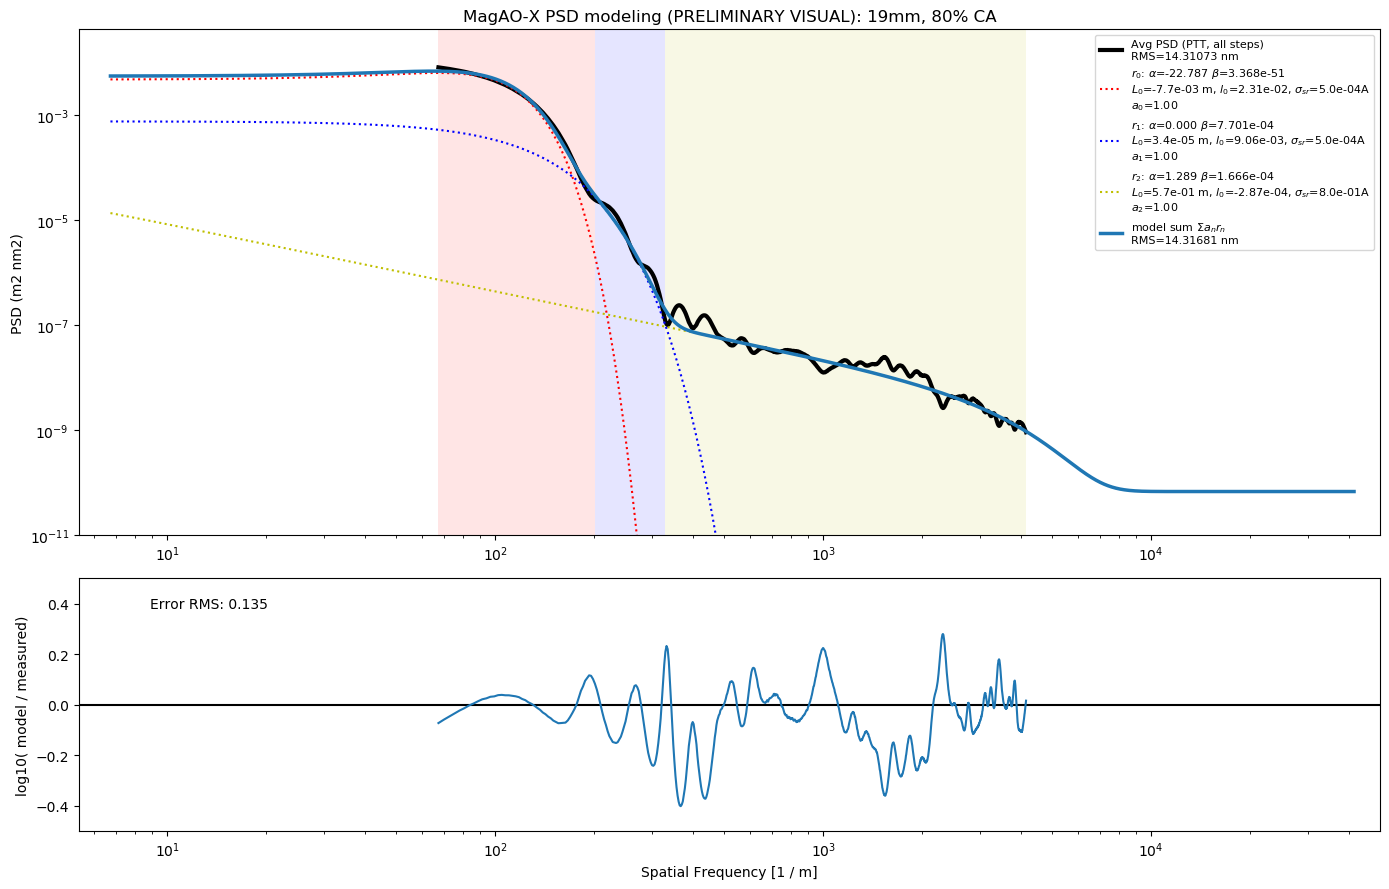

In [8]:
psd.plot_model2(mdl_set, ms_refit, fm, opt_parms)

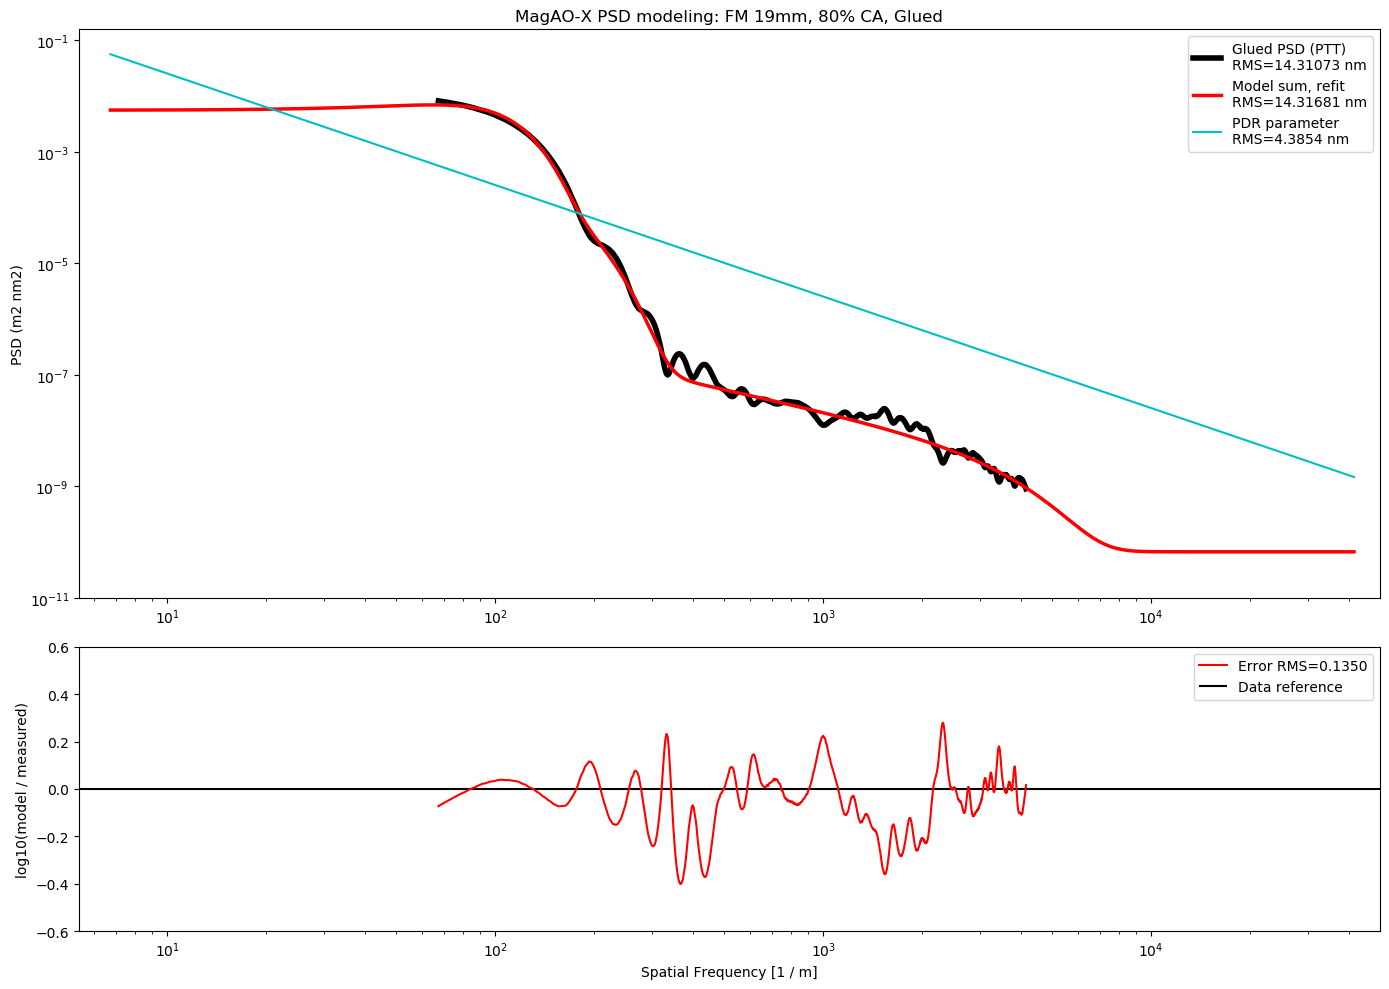

In [12]:
ap = 2.0
bp = 2.55 * (u.nm**2)
parm_pdr = [ap, bp, 0.0*u.m, 0.0, 0*(u.nm*u.m)**2]
psd_pdr = psd.model_full(k=mdl_set[0].k_range, psd_parm=parm_pdr)
pdr_weight = [1.0]

pdr_rms = psd.calc_model_rms(psd_parm=[parm_pdr], psd_weight=pdr_weight, 
                             npix_diam=ms_refit.npix_diam, delta_k=ms_refit.delta_k,
                             k_tgt_lim=[ms_refit.k_min, ms_refit.k_max])

k_radial = fm.k_radial.value
psd_radial = fm.psd_radial_cal.value
k_range_mdl = mdl_set[0].k_range.value

plt.figure(figsize=[14,10],dpi=100)
gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[4,2])
ax0 = plt.subplot(gs[0])  
ax0.loglog(k_radial, psd_radial, 'k', linewidth=4, 
           label='Glued PSD (PTT)\nRMS={0:.5f}'.format(fm.rms_tot))
ax0.loglog(k_range_mdl, ms_refit.psd_radial_sum.value, 'r', linewidth=2.5, 
           label='Model sum, refit\nRMS={0:.5f}'.format(ms_refit.psd_rms_sum))
ax0.loglog(k_range_mdl, psd_pdr.value, 'c', linewidth=1.5, label='PDR parameter\nRMS={0:.4f}'.format(pdr_rms))
ax0.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax0.set_ylim(bottom=1e-11)
ax0.set_ylabel('PSD ({0})'.format(ms_refit.psd_radial_sum.unit))
ax0.legend(prop={'size':10})#,loc='center left', bbox_to_anchor=(1, 0.5))
ax0.set_title('MagAO-X PSD modeling: FM 19mm, {0}% CA, Glued'.format(opt_parms['ca']))

ax1 = plt.subplot(gs[1])
ax1.hlines(y=0, xmin=np.amin(k_range_mdl)*0.8, xmax=np.amax(k_range_mdl)*1.2, color='k', label='Data reference')
ax1.semilogx(k_radial, ms_refit.error, 'r', label='Error RMS={0:.4f}'.format(ms_refit.error_rms))
ax1.legend(prop={'size':10})
ax1.set_ylim(top=0.6, bottom=-0.6)
ax1.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax1.set_ylabel('log10(model / measured)')
ax1.set_xlabel('Spatial Frequency [{0}]'.format(ms_refit.k_radial_data.unit))

plt.tight_layout()

In [16]:
# Save the PSD values into a pickle to access later
psd_dict = {'psd_fm19mm_glue': ms_refit.psd_parm,
            'psd_fm19mm_glue_weight': psd_weight,
            'psd_fm19mm_glue_rms': fm.rms_tot}

# save the directory as a pickle
import pickle
filename='/home/jhen/XWCL/code/MagAOX/PSD/model_parameters/psd_parms_fm{0}_glue.pickle'.format(opt_parms['label'])
with open(filename,'wb') as psd_parameter_file:
    pickle.dump(psd_dict, psd_parameter_file, protocol=4)

In [17]:
# test the pickle
objects = []
with (open(filename, "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
            
objects

[{'psd_fm19mm_glue': [[-22.78653590339071,
    <Quantity 3.3676617e-51 m(24.78653590339071) nm2>,
    <Quantity -0.00770312 m>,
    0.023127680758737997,
    <Quantity 2.63103757e-17 m2 nm2>],
   [0.00014290175743078985,
    <Quantity 0.00077013 m(1.9998570982425692) nm2>,
    <Quantity 3.37735198e-05 m>,
    0.009057806059291209,
    <Quantity 2.63103757e-17 m2 nm2>],
   [1.2885160516889151,
    <Quantity 0.00016655 m(0.7114839483110849) nm2>,
    <Quantity 0.56818182 m>,
    -0.0002865617033588518,
    <Quantity 6.73545619e-11 m2 nm2>]],
  'psd_fm19mm_glue_weight': [1.0, 1.0, 1.0],
  'psd_fm19mm_glue_rms': <Quantity 14.31072599 nm>}]